In [6]:
import numpy as np
from sklearn.decomposition import PCA
from torchvision import datasets, transforms, models
from latentmi import lmi, ksg
import seaborn as sns
import torch
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from collections import Counter


import torch.nn as nn
import torch.optim as optim

device='cuda'

torch.manual_seed(212121)

In [7]:
import pandas as pd
import seaborn as sns

In [8]:
# define resnet model
class MobileNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetClassifier, self).__init__()
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        self.mobilenet.classifier[1] = nn.Linear(self.mobilenet.last_channel, num_classes)  # update final layer

    def forward(self, x):
        return self.mobilenet(x)
    
def train_model(model, dataloader, epochs=5, scale=0):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    model.train()

    best_loss = np.inf
    best_state = None 
    
    for epoch in range(epochs):
        total_loss = 0.0
        for inputs, labels in dataloader:
            inputs, labels = inputs.numpy(), labels.numpy()  # to numpy
            if scale > 0:
                inputs = gaussian_noise(inputs, scale)  # downsample
            inputs, labels = torch.tensor(inputs).to(device).float(), torch.tensor(labels).to(device)  # back to tensor

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

        if avg_loss < best_loss:
            best_loss = avg_loss
            best_state = model.state_dict()  # save the best so far! ⭐
            stale_epochs = 0
        else:
            stale_epochs += 1
            if stale_epochs >= 10:
                print("early stopping! no improvement :(")
                break

    if best_state is not None:
        model.load_state_dict(best_state)  # restore the champ! 🏆

    return model  # all done!


def gaussian_noise(images, scale):
    return np.random.normal(size=images.shape)*scale + images

# pca wrapper (top 16 pcs!)
def compute_pca(images, n_components=16):
    flat_images = images.reshape(images.shape[0], -1)
    scaler = StandardScaler()
    scaled_images = scaler.fit_transform(flat_images)  # normalize!
    pca = PCA(n_components=n_components)
    pcs = pca.fit_transform(scaled_images)
    return pcs

def resample_one_v_all(true_labels, target_label):
    target_indices = []
    other_indices = []
    for i, label in enumerate(true_labels):
        if target_label == label:
            target_indices.append(i)
        else:
            other_indices.append(i)

    other_indices = np.random.choice(other_indices, len(target_indices), replace=False)
    indices = np.concatenate([target_indices, other_indices])
    return indices.astype(int)


def estimate_mi_repr(model, dataloader, scale=0):
    model.eval()
    true_labels = []
    last_layer_reprs = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.numpy()  # to numpy
            if scale > 0:
                inputs = gaussian_noise(inputs, scale)  # downsample
            inputs = torch.tensor(inputs).to(device).float()  # back to tensor
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()

            true_labels.append(labels.numpy())
            last_layer_reprs.append(outputs.cpu().numpy())

    true_labels = np.concatenate(true_labels)
    last_layer_reprs = np.concatenate(last_layer_reprs)

    MIs = []
    N_samples = []
    labels = []

    for label in np.unique(true_labels):
        N_samples.append(np.sum(true_labels == label))
        labels.append(label)
        idx = resample_one_v_all(true_labels, label)
        bin_y = true_labels[idx] == label
        reprs = last_layer_reprs[idx]
        
        MIs.append(np.nanmean(lmi.estimate(bin_y.reshape(-1, 1), reprs)[0]))

    # all labels → one-hot!
    uniques = np.unique(true_labels).tolist()
    n_classes = len(uniques)
    one_hot_labels = np.eye(n_classes)[[uniques.index(s) for s in true_labels]]
    MIs.append(np.nanmean(lmi.estimate(one_hot_labels, last_layer_reprs, N_dims=16)[0]))
    N_samples.append(len(true_labels))
    labels.append('all')

    print(MIs)

    return MIs, N_samples, labels


In [9]:
transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB") if img.mode != "RGB" else img),  # ensure RGB
    transforms.Resize((240, 240)),  # resize to a manageable resolution
    transforms.ToTensor(),  # convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # normalize
])

# load dataset
Caltech101 = datasets.Caltech101(root='../data', download=True, transform=transform)

# get class labels
labels = Caltech101.y  # class indices for the dataset

# count occurrences of each class
class_counts = Counter(labels)

# find top n largest classes
top_n = 5
top_n_classes = [cls for cls, _ in class_counts.most_common(top_n)]

# subset the dataset to include only samples from these top classes
indices = [i for i, label in enumerate(labels) if label in top_n_classes]
subset = torch.utils.data.Subset(Caltech101, indices)

# split the subset into train and validation sets
N = len(subset)
print(f"{N} total samples")
train_set, val_set = torch.utils.data.random_split(subset, [N//2, N - N//2])

# create data loaders
data_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False)

Files already downloaded and verified
2707 total samples


In [10]:
d = {
    "Scale" : [],
    "MI" : [],
    "Class label" : [],
    "N instances of label" : []
}

MIs = []
scales = np.logspace(-1, 2, 10)

# process each factor
for scale in scales:

    model = MobileNetClassifier(num_classes=101)
    model.to('cuda')
    train_model(model, data_loader, epochs=5, scale=scale)

    # estimate mutual info
    mi, n_inst, labels = estimate_mi_repr(model, val_loader, scale=scale)
    d['MI'] += mi
    d['Scale'] += [scale] * len(mi)
    d['Class label'] += labels
    d["N instances of label"] += n_inst

Epoch 1/5, Loss: 3.0612
Epoch 2/5, Loss: 0.5488
Epoch 3/5, Loss: 0.0844
Epoch 4/5, Loss: 0.0362
Epoch 5/5, Loss: 0.0182
epoch 299 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻[0.9979821042076013, 0.9964786536314015, 0.9992929705429503, 1.0006647962050639, 0.9902742389434632, 2.1813303004491233]


/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Loss: 3.0509
Epoch 2/5, Loss: 0.5844
Epoch 3/5, Loss: 0.1063
Epoch 4/5, Loss: 0.0414
Epoch 5/5, Loss: 0.0245
epoch 299 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻[0.9979821042076007, 0.9792433330172435, 0.9975290138120176, 0.9989807060369469, 0.9958340124015764, 2.1716699461644176]


/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Loss: 3.1324
Epoch 2/5, Loss: 0.7052
Epoch 3/5, Loss: 0.1213
Epoch 4/5, Loss: 0.0530
Epoch 5/5, Loss: 0.0348
epoch 295 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻[0.9983481599214387, 0.9716456388949222, 0.9967982176340644, 0.9934873483804949, 0.9251533870660849, 2.1845392647298136]


/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Loss: 3.4163
Epoch 2/5, Loss: 1.1034
Epoch 3/5, Loss: 0.3057
Epoch 4/5, Loss: 0.1378
Epoch 5/5, Loss: 0.0785
epoch 299 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻[0.979767992078261, 0.9505860566619319, 0.9699632816543613, 0.9520613464466681, 0.8725210709279034, 2.114891830950419]


/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Loss: 3.6655
Epoch 2/5, Loss: 1.4529
Epoch 3/5, Loss: 0.6071
Epoch 4/5, Loss: 0.3376
Epoch 5/5, Loss: 0.1846
epoch 259 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻[0.9827191723817438, 0.9588638408880742, 0.9242317330269044, 0.886083601848997, 0.814754053449824, 1.9974624000262622]


/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Loss: 4.0030
Epoch 2/5, Loss: 2.1781
Epoch 3/5, Loss: 1.1479
Epoch 4/5, Loss: 0.7720
Epoch 5/5, Loss: 0.6181
epoch 182 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻[0.7435768387138082, 0.6623448118722705, 0.7112354774041645, 0.7246680833970287, 0.5596835237808133, 1.528139425720864]


/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Loss: 4.0076
Epoch 2/5, Loss: 2.5916
Epoch 3/5, Loss: 1.6009
Epoch 4/5, Loss: 1.1288
Epoch 5/5, Loss: 0.9152
epoch 173 (of max 300) 🌻🌻🌻🌻🌻🌻[0.38778817532271714, 0.5014087987948366, 0.6462861489281833, 0.48194811092953443, 0.09935970612414381, 1.0517859670936676]


/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Loss: 4.3182
Epoch 2/5, Loss: 3.0518
Epoch 3/5, Loss: 2.1631
Epoch 4/5, Loss: 1.6295
Epoch 5/5, Loss: 1.4128
epoch 107 (of max 300) 🌻🌻🌻🌻🌻[0.16089176320961404, 0.12386837584706381, 0.4229121441585973, 0.06694786692598917, -0.06575208477773838, 0.47331713325134767]


/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Loss: 3.9871
Epoch 2/5, Loss: 2.8305
Epoch 3/5, Loss: 2.1247
Epoch 4/5, Loss: 1.7747
Epoch 5/5, Loss: 1.6475
epoch 149 (of max 300) 🌻🌻🌻🌻[-0.023021296909295087, -0.04816324511016649, 0.06510958366168837, 0.04239990244882782, 0.014828850360244741, 0.029746324763408747]


/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Loss: 4.0349
Epoch 2/5, Loss: 2.8845
Epoch 3/5, Loss: 2.1632
Epoch 4/5, Loss: 1.8142
Epoch 5/5, Loss: 1.6744
epoch 135 (of max 300) 🌻🌻🌻🌻[0.008504359623649184, -0.03612210289538342, 0.012961122748465814, -0.057939494437794566, 0.004885139180825523, -0.03857076092522751]


In [11]:
df = pd.DataFrame(data=d)
df.to_csv('../results/Caltech101_lastlayer.csv')

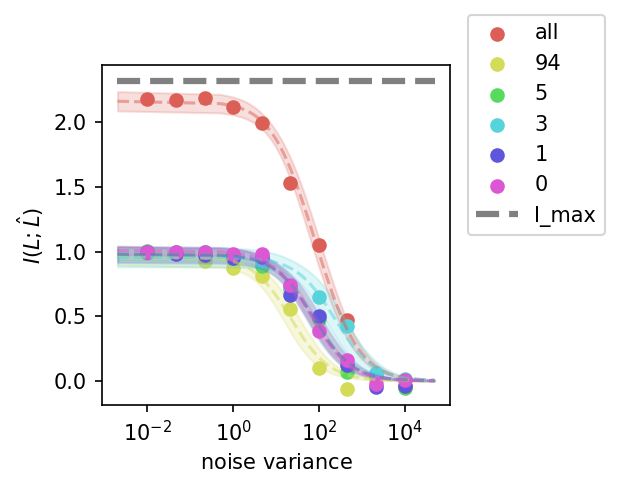

In [12]:
from lmfit import Model

def info_scaling(x, A, B):
    return 0.5 * np.log2(((1/x)*B+ 1)/(1+A*(1/x)))

fig = plt.figure(figsize=(3,3), dpi=150)


classes = df[df['N instances of label'] > 100]['Class label'].unique()
palette = sns.color_palette("hls", len(classes))

for i, x in enumerate(classes[::-1]):
    # prepare data
    x_data = df[df['Class label'] == x]['Scale']**2
    y_data = df[df['Class label'] == x]['MI']

    # create model and parameters
    model = Model(info_scaling)
    params = model.make_params(A=1e-2, B=1e-2)  # initial guesses
    params['A'].min = 0  # set bounds
    params['B'].min = 0

    # fit model
    result = model.fit(y_data, params, x=x_data)

    # generate fit line
    x_fit = np.linspace(x_data.min()/5, 5*x_data.max(), 10**5)
    y_fit = model.eval(params=result.params, x=x_fit)

    # calculate confidence bands
    y_upper = result.eval_uncertainty(params=result.params, 
                                      x=x_fit, sigma=2)
    y_lower = -y_upper

    # plot fit and data
    plt.plot(x_fit, y_fit, linestyle='--', color=palette[i], alpha=0.5)
    plt.fill_between(x_fit, y_fit + y_upper, y_fit + y_lower, color=palette[i], alpha=0.2)
    plt.scatter(x_data, y_data, color=palette[i], label=x)

I_max = np.log2(top_n)
plt.plot([np.min(x_fit), np.max(x_fit)], [I_max, I_max], linestyle='--', 
         color='grey', label='I_max', lw=3)


plt.xlabel(r'$\text{noise variance}$')
plt.ylabel(r'$I(L; \hat{L})$')
plt.xscale('log')
plt.legend(loc=(1.05, 0.5))